## Пример множественной линейной регрессии

### Подготовка переменных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler

In [2]:
df = pd.read_excel('v2_funding_rounds.xlsx', sheet_name=0, header=0)
df

,Money Raised (in USD),Announced Date,Organization Name,Funding Type (dummy),Organization Industries,ВВП на душу населения,Уровень процентных ставок,Инфляция,Темпы роста экономики,Индекс глобальной инновационной активности (GII),Доля корпоративных венчурных фондов (CVC),Доля государственного финансирования в венчурных инвестициях,Индекс политической стабильности
0,4000000,2012-03-02,Zoona,Series A,"Financial Services, FinTech, Mobile, Software",434.40,0.050,0.056,0.025,37.40,0.03,0.49,0.60
1,750000,2014-06-02,Wyzetalk,Series A,Information Technology,381.20,0.055,0.061,0.015,38.25,0.12,0.41,0.60
2,800000,2015-07-09,Faithful to Nature,Seed,"E-Commerce, Food and Beverage, Health Care, Or...",346.66,0.060,0.046,0.013,37.45,0.15,0.44,0.60
3,2000,2016-03-14,South African Digital Enterprise,Pre-Seed,"Digital Marketing, Digital Media, Telecommunic...",323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60
4,9000000,2016-10-19,SPARK Schools,Series B,"Charter Schools, Education, Skill Assessment",323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,400000,2024-09-12,Pumpkn,Seed,"Financial Services, FinTech, Small and Medium ...",403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74
205,1819175,2024-09-17,Happy Pay,Pre-Seed,"Finance, Financial Services, Shopping",403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74
206,250000,2024-11-07,Abalobi,Seed,"Mobile, Mobile Apps, Software",403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74
207,120000,2024-12-22,Starbuy Exchange,Seed,"Cryptocurrency, FinTech",403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74


In [3]:
# преобразование иерархической номинативной переменной
df['Funding Type (dummy)'] = df['Funding Type (dummy)'].map({'Pre-Seed':1, 'Seed':2, 'Series A':3, 'Series B':4})

In [4]:
# предикторы выбраны заказчиком
df_for_reg_model = df.copy(deep=True)
df_for_reg_model = df_for_reg_model.reindex(columns=['Money Raised (in USD)', 'ВВП на душу населения', 'Уровень процентных ставок', 'Инфляция', 'Темпы роста экономики',
                                                     'Индекс глобальной инновационной активности (GII)', 'Доля корпоративных венчурных фондов (CVC)',
                                                     'Доля государственного финансирования в венчурных инвестициях', 'Индекс политической стабильности', 'Funding Type (dummy)'])
df_for_reg_model.head(3)

,Money Raised (in USD),ВВП на душу населения,Уровень процентных ставок,Инфляция,Темпы роста экономики,Индекс глобальной инновационной активности (GII),Доля корпоративных венчурных фондов (CVC),Доля государственного финансирования в венчурных инвестициях,Индекс политической стабильности,Funding Type (dummy)
0,4000000,434.40,0.050,0.056,0.025,37.40,0.03,0.49,0.6,3
1,750000,381.20,0.055,0.061,0.015,38.25,0.12,0.41,0.6,3
2,800000,346.66,0.060,0.046,0.013,37.45,0.15,0.44,0.6,2


In [5]:
reg_model_dict = {'Money Raised (in USD)':'y',
                  'ВВП на душу населения':'x_1',
                  'Уровень процентных ставок':'x_2',
                  'Инфляция':'x_3',
                  'Темпы роста экономики':'x_4',
                  'Индекс глобальной инновационной активности (GII)':'x_5',
                  'Доля корпоративных венчурных фондов (CVC)':'x_6',
                  'Доля государственного финансирования в венчурных инвестициях':'x_7',
                  'Индекс политической стабильности':'x_8',
                  'Funding Type (dummy)': 'x_9'}
df_for_reg_model = df_for_reg_model.rename(columns=reg_model_dict)

> меняем названия у колонок, чтобы в коде не возникали конфликты с названиями переменных (формулы statsmodels конфликтуют с пробелами с названиями) + на графиках визуально легче воспринимать короткие названия переменных

> у - это зависимая переменная, все остальные - пронумерованные предикторы х

In [6]:
df_for_reg_model

,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,4000000,434.40,0.050,0.056,0.025,37.40,0.03,0.49,0.60,3
1,750000,381.20,0.055,0.061,0.015,38.25,0.12,0.41,0.60,3
2,800000,346.66,0.060,0.046,0.013,37.45,0.15,0.44,0.60,2
3,2000,323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60,1
4,9000000,323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60,4
...,...,...,...,...,...,...,...,...,...,...
204,400000,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2
205,1819175,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,1
206,250000,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2
207,120000,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2


### Первичная оценка переменных и модели

In [7]:
y = df_for_reg_model['y']
x = sm.add_constant(df_for_reg_model[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']])

# первичная модель
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     8.573
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           8.01e-11
Time:                        21:58:10   Log-Likelihood:                -3637.0
No. Observations:                 209   AIC:                             7294.
Df Residuals:                     199   BIC:                             7327.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.577e+07   1.86e+08     -0.407      0.6

>**Первичная модель** показывает низкую предсказательную силу, согласно скорректированному R-квадрат (<50%) и тесту Харке-Бера (анализ остатков), который сильно > 0. Также о ненормальности распределения остатков говорит показатель распределения остатков Omnibus (>0)
>
>Оценим и при необходимости нормализуем переменные:

<Axes: >

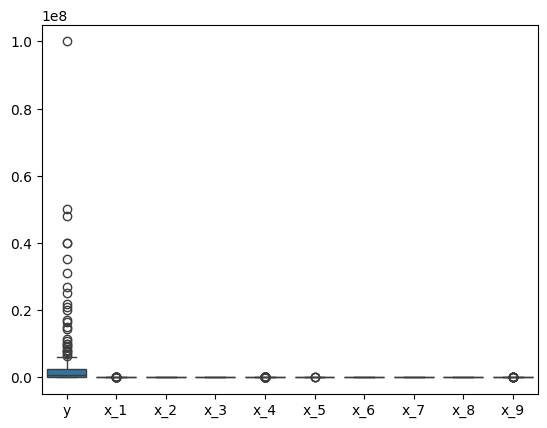

In [8]:
# распределение переменных
sns.boxplot(data=df_for_reg_model)

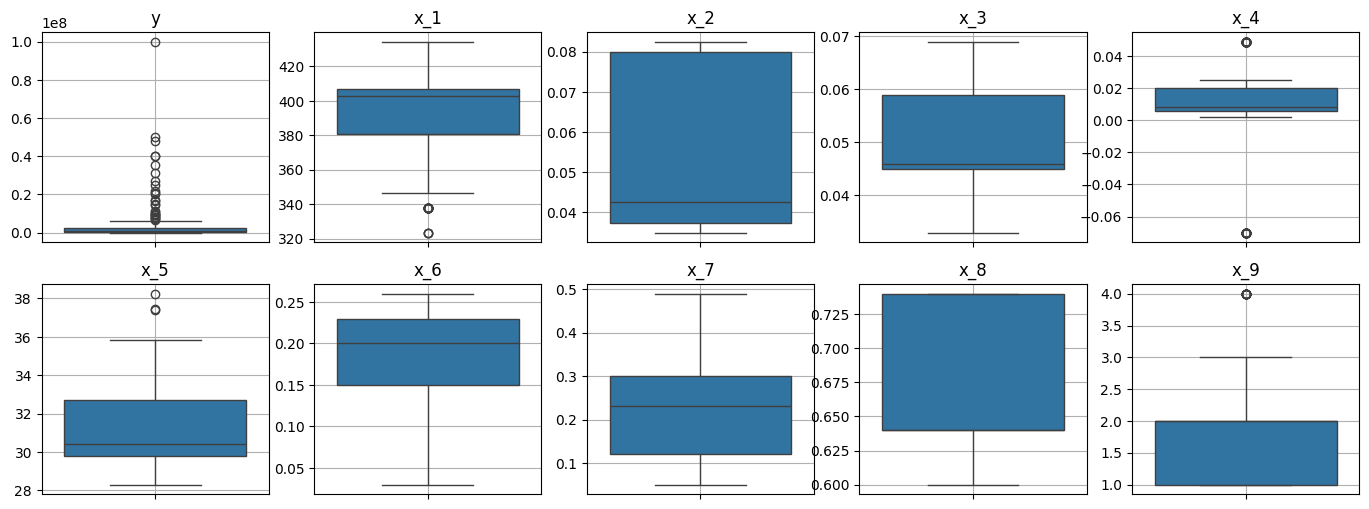

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(17, 6))

num_plots = len(df.columns)
for ax, col in zip(axes.flatten()[:num_plots], df_for_reg_model.columns):
    sns.boxplot(data=df_for_reg_model[col], ax=ax)
    ax.set_title(f'{col}')
    ax.set_ylabel('')
    ax.grid(True)

array([[<Axes: title={'center': 'y'}>, <Axes: title={'center': 'x_1'}>,
        <Axes: title={'center': 'x_2'}>],
       [<Axes: title={'center': 'x_3'}>, <Axes: title={'center': 'x_4'}>,
        <Axes: title={'center': 'x_5'}>],
       [<Axes: title={'center': 'x_6'}>, <Axes: title={'center': 'x_7'}>,
        <Axes: title={'center': 'x_8'}>],
       [<Axes: title={'center': 'x_9'}>, <Axes: >, <Axes: >]],
      dtype=object)

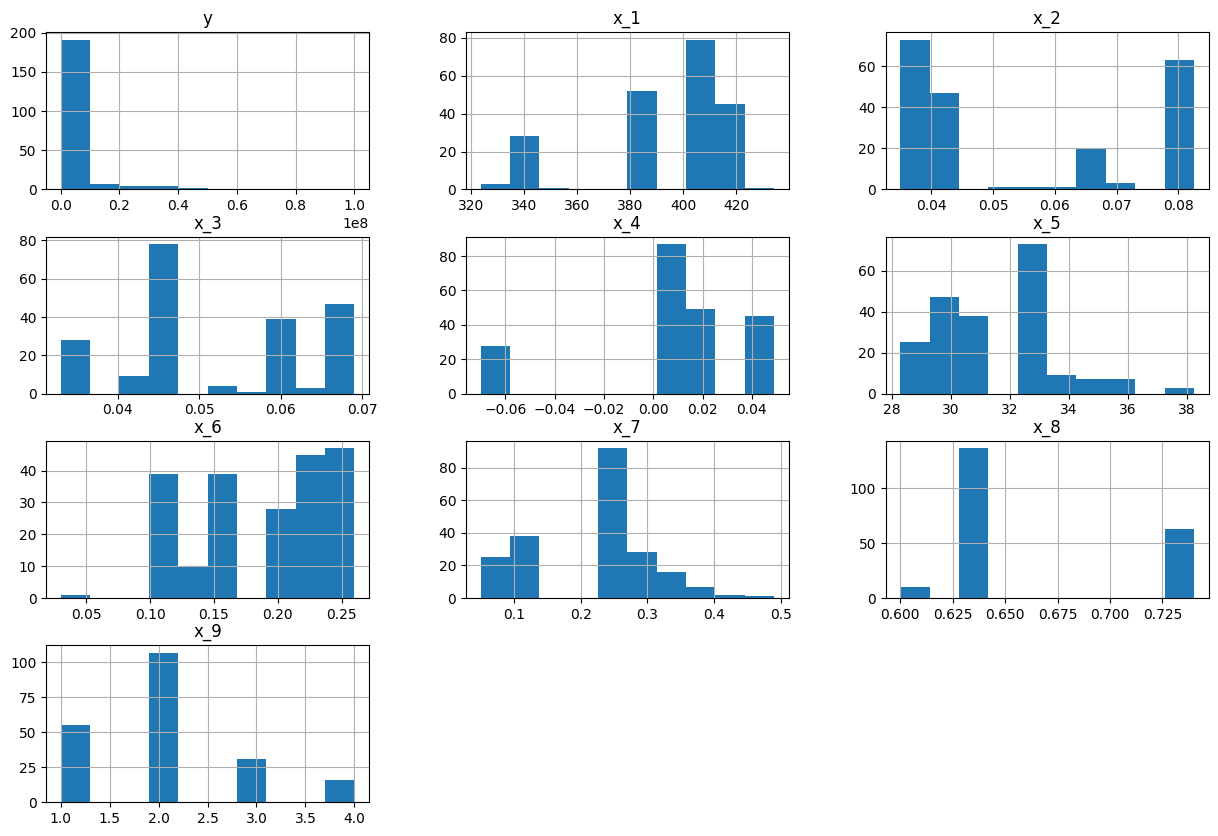

In [10]:
df_for_reg_model.hist(figsize=(15, 10), bins=10)

In [11]:
for col in df_for_reg_model.columns:
    print(f'{col}: {stats.shapiro(df_for_reg_model[col])}')

y: ShapiroResult(statistic=np.float64(0.39988715766449345), pvalue=np.float64(7.117113362082922e-26))
x_1: ShapiroResult(statistic=np.float64(0.8283802490718777), pvalue=np.float64(1.9236404224003765e-14))
x_2: ShapiroResult(statistic=np.float64(0.7695277550265363), pvalue=np.float64(8.191475724033384e-17))
x_3: ShapiroResult(statistic=np.float64(0.8797850174250292), pvalue=np.float64(7.644362477552049e-12))
x_4: ShapiroResult(statistic=np.float64(0.772864408780117), pvalue=np.float64(1.0846065824377489e-16))
x_5: ShapiroResult(statistic=np.float64(0.9040508085418458), pvalue=np.float64(2.4043550420559583e-10))
x_6: ShapiroResult(statistic=np.float64(0.8837071872649491), pvalue=np.float64(1.290898079669305e-11))
x_7: ShapiroResult(statistic=np.float64(0.9180424324217777), pvalue=np.float64(2.2898847086472558e-09))
x_8: ShapiroResult(statistic=np.float64(0.6569971930385263), pvalue=np.float64(2.5275059232293356e-20))
x_9: ShapiroResult(statistic=np.float64(0.8274241977995683), pvalue=np

> ни одно из распределений не является нормальным (за исключением х_9, это порядковая номинативная переменная), но не каждую будем нормализовать
> 
> в первую очередь в нормализации нуждаются переменные:
> - с выбросами
> - с выделяющимися единицами измерения
> 
> нормализовать будем: у (логарифмированием, из-за правосторонней ассиметрии), x_1, x_5 (методом RobustScaler в scikit-learn)

In [12]:
# избавляемся от пропусков, если есть
df_for_reg_model = df_for_reg_model.dropna(how='any').reset_index(drop=True)
# логарифмирование у
df_for_reg_model['y'] = np.log2(df_for_reg_model['y'])

In [13]:
# робастная нормализация x_1, x_4, x_5
columns_to_scale = ['x_1', 'x_5']
# scaler = StandardScaler()
scaler = RobustScaler()
df_for_reg_model[columns_to_scale] = scaler.fit_transform(df_for_reg_model[columns_to_scale])

array([[<Axes: title={'center': 'y'}>, <Axes: title={'center': 'x_1'}>,
        <Axes: title={'center': 'x_2'}>],
       [<Axes: title={'center': 'x_3'}>, <Axes: title={'center': 'x_4'}>,
        <Axes: title={'center': 'x_5'}>],
       [<Axes: title={'center': 'x_6'}>, <Axes: title={'center': 'x_7'}>,
        <Axes: title={'center': 'x_8'}>],
       [<Axes: title={'center': 'x_9'}>, <Axes: >, <Axes: >]],
      dtype=object)

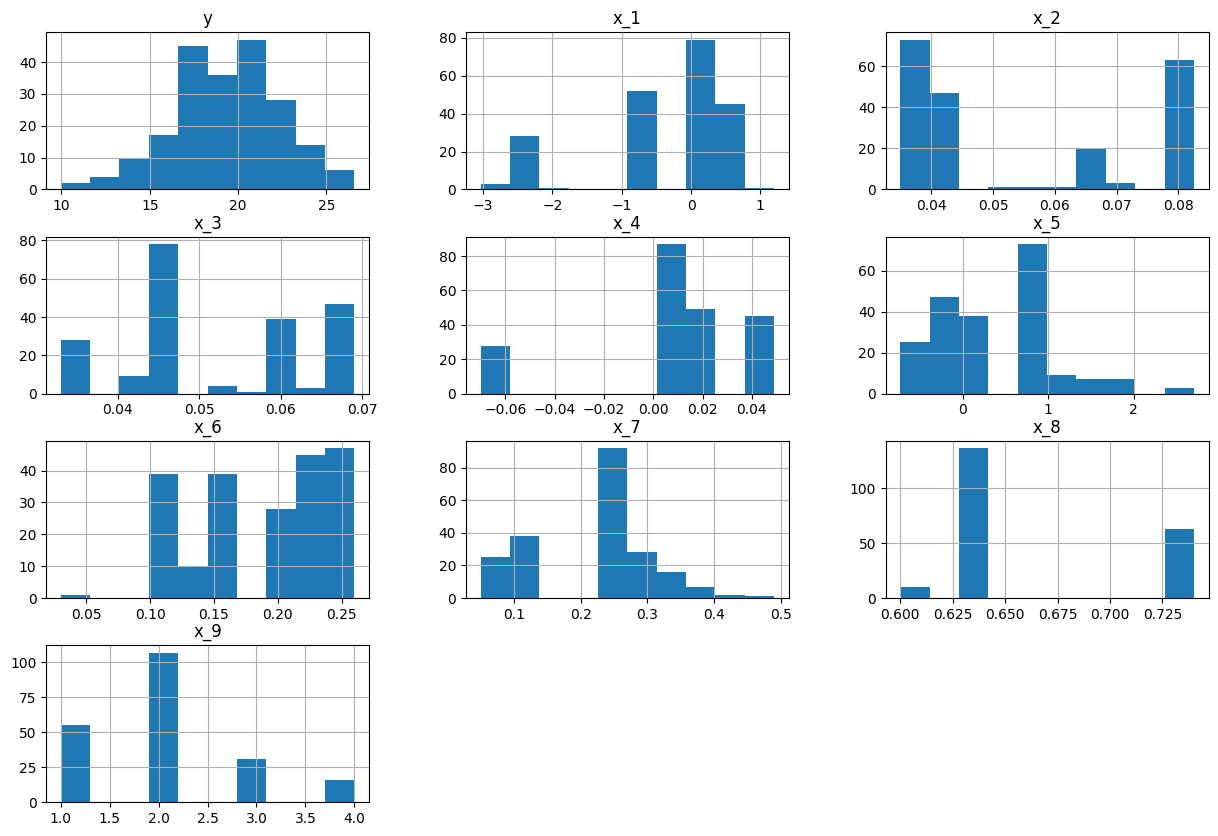

In [14]:
df_for_reg_model.hist(figsize=(15, 10), bins=10)

In [15]:
y = df_for_reg_model['y']
x = sm.add_constant(df_for_reg_model[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']])

# модель после шкалирования переменных
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     17.34
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           5.15e-21
Time:                        21:58:12   Log-Likelihood:                -464.15
No. Observations:                 209   AIC:                             948.3
Df Residuals:                     199   BIC:                             981.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -67.0772     34.527     -1.943      0.0

> **Модель со всеми переменными**

> - построив модель со всеми переменными Х, мы получили R-квадрат с поправкой на множественное сравнение (Adj. R-square) равный 41%
> - снился AIC (информационный критерий Акаике) и увеличился Log-Likelihood (значение правдоподобия)
> - показатель распределения остатков (Omnibus) и тест Харке-Бера тоже снизились, но всё ещё больше 0
> - t-статистика и p-value показывают недостаточную значимость большинства предикторов для модели на данном этапе её построения

> Стоит улучшить подель проверкой на мультиколлинеарность

### Проверка на мультиколлинеарность

<Axes: >

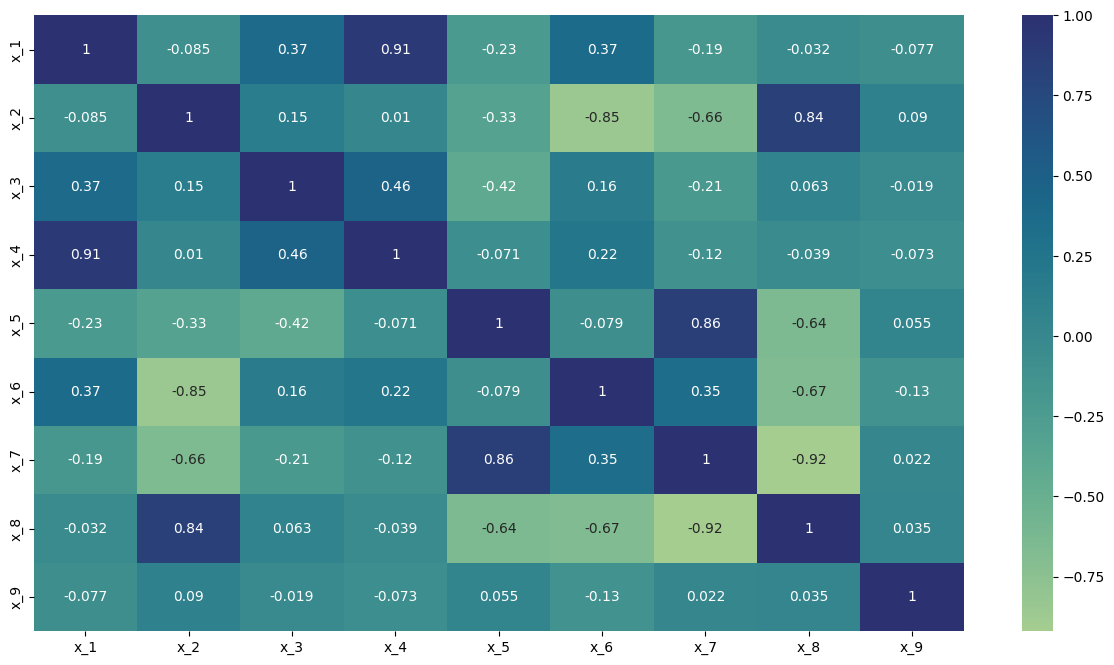

In [16]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_for_reg_model[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']].corr(), annot=True, cbar=True, cmap='crest')

> уберём x_2 (Уровень процентных ставок), x_4 (Темпы роста экономики), x_8 (Индекс политической стабильности), х_7 (Доля государственного финансирования в венчурных инвестициях) из-за наличия тесной линейной зависимости с остальными предикторами

In [17]:
# убираем 2 столбца: x_2, x_4, х_7, x_8

df_for_reg_model = df_for_reg_model.reindex(columns=['y', 'x_1', 'x_3', 'x_5', 'x_6', 'x_9'])

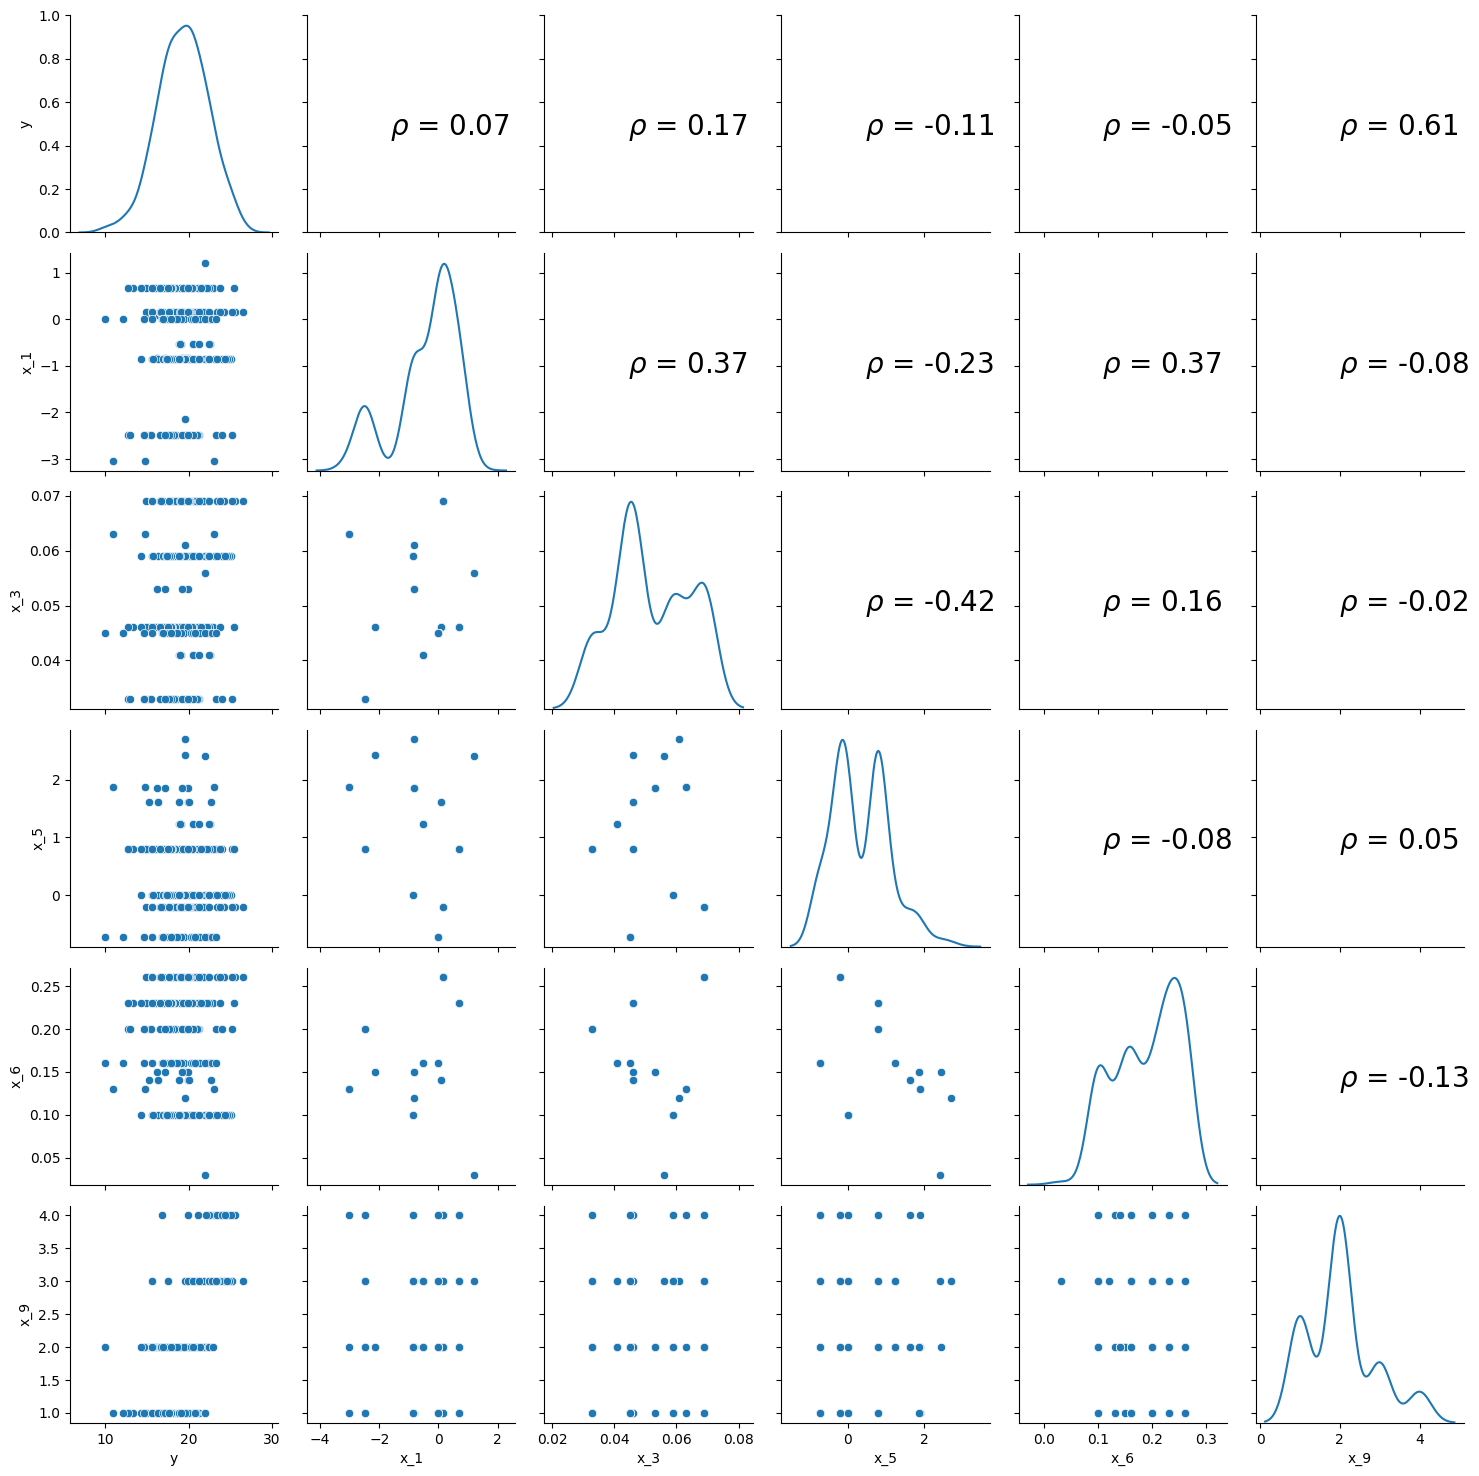

In [18]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.4, 0.45), size = 20, xycoords = ax.transAxes)

g = sns.PairGrid(df_for_reg_model, diag_sharey=False)
g.map_upper(corr)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

### Подбор наилучшей модели

In [19]:
y = df_for_reg_model['y']
x = sm.add_constant(df_for_reg_model[['x_1', 'x_3', 'x_5', 'x_6', 'x_9']])

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     28.41
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           8.70e-22
Time:                        21:58:14   Log-Likelihood:                -469.21
No. Observations:                 209   AIC:                             950.4
Df Residuals:                     203   BIC:                             970.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6569      1.121     12.177      0.0

In [20]:
# Исходный набор переменных
fits = {'x_1', 'x_3', 'x_5', 'x_6', 'x_9'}

def check_all_x(params: set, formula: str, result: set, include_interactions: bool = True) -> None:
    if not params:
        # Добавляем формулу в результат, убирая лишние пробелы
        if formula:  # Проверяем, что формула не пустая
            result.add(formula.lstrip('+ '))
        return
    else:
        new_params = params.copy()
        for el in params:
            new_params.remove(el)
            
            # Вариант с добавлением переменной через +
            check_all_x(new_params, formula + ' + ' + el, result, include_interactions)
            
            # Вариант без добавления переменной
            check_all_x(new_params, formula, result, include_interactions)
            
            # Если нужно генерировать взаимодействия
            if include_interactions:
                # Добавляем только попарные взаимодействия
                # Создаем список существующих переменных без взаимодействий
                existing_vars = set()
                for term in formula.split('+'):
                    term = term.strip()
                    if term:
                        # Проверяем, что это не взаимодействие
                        if '*' not in term:
                            existing_vars.add(term)
                
                # Формируем попарные взаимодействия
                for existing_var in existing_vars:
                    interaction = f"{existing_var}*{el}"
                    check_all_x(new_params, formula + ' + ' + interaction, result, include_interactions)

# Собираем все возможные формулы
res = set()          
check_all_x(fits, '', res)

# Дальнейшая обработка остается прежней
import pandas as pd
import statsmodels.formula.api as smf

df_fits = pd.DataFrame(columns=['adj_r-square', 'aic', 'fits'])

for formula in res:
    lm = smf.ols(formula='y ~ ' + formula, data=df_for_reg_model).fit()
    df_fits = pd.concat([df_fits, pd.DataFrame([{'adj_r-square':lm.rsquared_adj, 'aic': lm.aic, 'fits':formula}])], ignore_index=True)


C:\Users\Сестра\AppData\Local\Temp\ipykernel_16196\140345641.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_fits = pd.concat([df_fits, pd.DataFrame([{'adj_r-square':lm.rsquared_adj, 'aic': lm.aic, 'fits':formula}])], ignore_index=True)


In [21]:
pd.set_option('display.max_colwidth',None)

> **выбор оптимальной модели**

> в модели множественной регрессии можно попытаться поднять значение R-квадрата и уменьшить значение AIC путём перебирания в модели разных наборов переменных Х (помимо уже полученной модели со всеми иксами)


наименования переменных
   - {'Money Raised (in USD)':'y',
   - 'ВВП на душу населения':'x_1',
   - 'Уровень процентных ставок':'x_2',
   - 'Инфляция':'x_3',
   - 'Темпы роста экономики':'x_4',
   - 'Индекс глобальной инновационной активности (GII)':'x_5',
   - 'Доля корпоративных венчурных фондов (CVC)':'x_6',
   - 'Доля государственного финансирования в венчурных инвестициях':'x_7',
   - 'Индекс политической стабильности':'x_8',
   - 'Funding Type (dummy)': 'x_9'}

In [22]:
# сортировка по R-квадрат
df_fits.sort_values(by='adj_r-square', ascending=False).head(10)

,adj_r-square,aic,fits
136,0.423250,943.126723,x_1 + x_1*x_9 + x_1*x_3 + x_1*x_6
158,0.421007,944.895444,x_1 + x_1*x_9 + x_5 + x_1*x_3 + x_1*x_6
0,0.420518,943.151581,x_1 + x_9 + x_1*x_3 + x_1*x_6
216,0.420251,944.210594,x_1 + x_1*x_9 + x_5 + x_5*x_3 + x_6
127,0.419204,945.545224,x_1 + x_1*x_9 + x_5 + x_1*x_3 + x_5*x_6
17,0.418377,944.885159,x_1 + x_9 + x_5 + x_1*x_3 + x_1*x_6
148,0.418104,946.893224,x_1 + x_1*x_9 + x_1*x_5 + x_1*x_3 + x_1*x_6
222,0.417968,945.989653,x_1 + x_1*x_9 + x_5 + x_5*x_3 + x_5*x_6
2,0.417686,945.133191,x_1 + x_9 + x_5 + x_5*x_3 + x_9*x_6
111,0.417394,946.195675,x_1 + x_1*x_9 + x_5 + x_5*x_3 + x_1*x_6


In [23]:
# сортировка по AIC
df_fits.sort_values(by='aic', ascending=True).head(10)

,adj_r-square,aic,fits
136,0.423250,943.126723,x_1 + x_1*x_9 + x_1*x_3 + x_1*x_6
0,0.420518,943.151581,x_1 + x_9 + x_1*x_3 + x_1*x_6
216,0.420251,944.210594,x_1 + x_1*x_9 + x_5 + x_5*x_3 + x_6
123,0.417322,944.301032,x_1 + x_9 + x_5 + x_5*x_3 + x_6
81,0.415784,944.851920,x_1 + x_1*x_9 + x_1*x_5 + x_3
17,0.418377,944.885159,x_1 + x_9 + x_5 + x_1*x_3 + x_1*x_6
158,0.421007,944.895444,x_1 + x_1*x_9 + x_5 + x_1*x_3 + x_1*x_6
152,0.412944,944.897586,x_1 + x_9 + x_1*x_5 + x_3
2,0.417686,945.133191,x_1 + x_9 + x_5 + x_5*x_3 + x_9*x_6
192,0.409157,945.268565,x_9 + x_3 + x_3*x_5


{'Money Raised (in USD)':'y',
                  'ВВП на душу населения':'x_1',
                  'Уровень процентных ставок':'x_2',
                  'Инфляция':'x_3',
                  'Темпы роста экономики':'x_4',
                  'Индекс глобальной инновационной активности (GII)':'x_5',
                  'Доля корпоративных венчурных фондов (CVC)':'x_6',
                  'Доля государственного финансирования в венчурных инвестициях':'x_7',
                  'Индекс политической стабильности':'x_8',
                  'Funding Type (dummy)': 'x_9'}

>предложенные выше формулы отсортированы по наибольшему Adj. R-squared и наименьшему AIC, но при выборе наиболее оптимальной формулы не стоит также забывать о логике, стоящей за переменными: не все взаимодействия, предложенные перебором, имеют под собой смысл
>
>x_1 * x_9 ('ВВП на душу населения' * 'Funding Type') как пара взаимодействующих предикторов не представляют собой ценности
>
>а вот x_3 * x_5 ('Инфляция' * 'Индекс глобальной инновационной активности') и x_3 * x_6 ('Инфляция' * 'Доля корпоративных венчурных фондов') имеют под собой финансовый смысл

In [24]:
# модель с наибольшим R-квадрат (с поправкой), с учётом отброса некоторых взаимодействий предикторов

y = df_for_reg_model['y']
formula = 'x_3 + x_1 + x_3*x_6 + x_9 + x_3*x_5'

model = smf.ols(formula='y ~ ' + formula, data=df_for_reg_model).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     22.34
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           3.15e-22
Time:                        21:58:15   Log-Likelihood:                -464.51
No. Observations:                 209   AIC:                             945.0
Df Residuals:                     201   BIC:                             971.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4662      5.532      1.350      0.1

>если оценить поведение предикторов в самой модели, то становится понятным, что сочетание x_3 * x_6 ('Инфляция' * 'Доля корпоративных венчурных фондов') в модель не вписывается: слишком велики стандартная ошибка и доверительные интервалы
>
>также по причине недостаточной значимости p-value у x_1, исключаем и эту переменную

In [25]:
# итоговая модель

y = df_for_reg_model['y']
formula = 'x_9 + x_3*x_5'

model = smf.ols(formula='y ~ ' + formula, data=df_for_reg_model).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     37.01
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           2.97e-23
Time:                        21:58:15   Log-Likelihood:                -467.63
No. Observations:                 209   AIC:                             945.3
Df Residuals:                     204   BIC:                             962.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3830      0.983     12.601      0.0

### Анализ остатков

C:\Users\Сестра\AppData\Local\Temp\ipykernel_16196\1218368659.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model.resid, fit=stats.norm)


<Axes: ylabel='Density'>

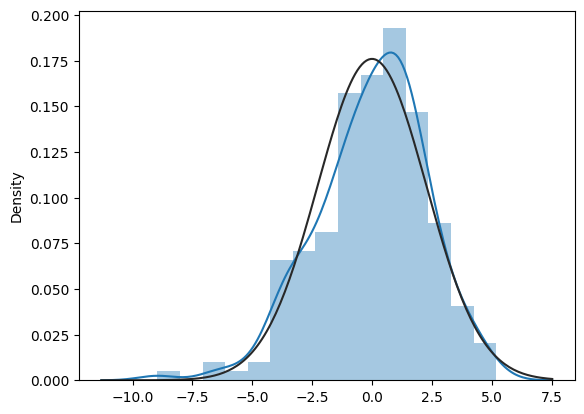

In [26]:
sns.distplot(model.resid, fit=stats.norm)

<Axes: >

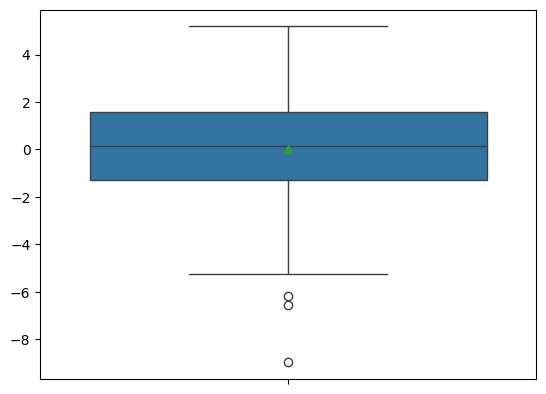

In [27]:
sns.boxplot(model.resid, showmeans=True)

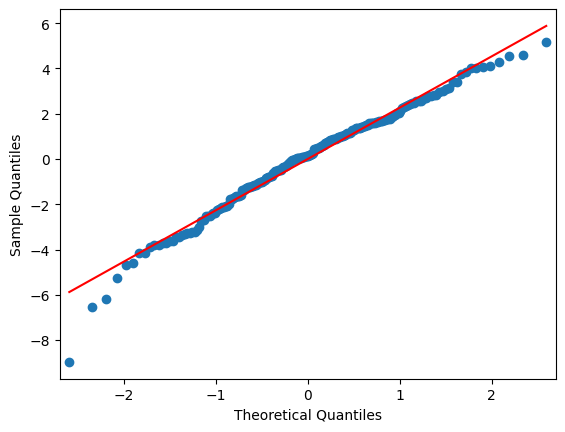

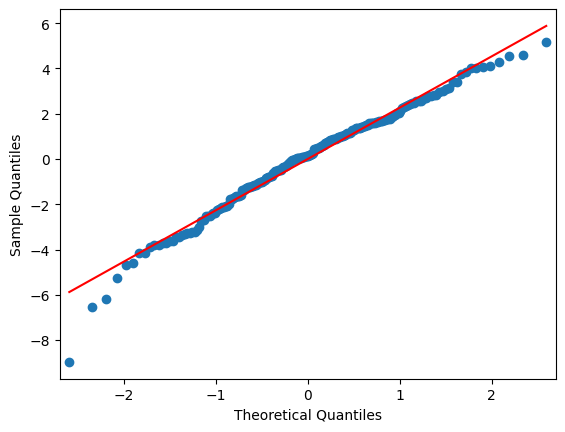

In [28]:
sm.qqplot(model.resid, line='s')

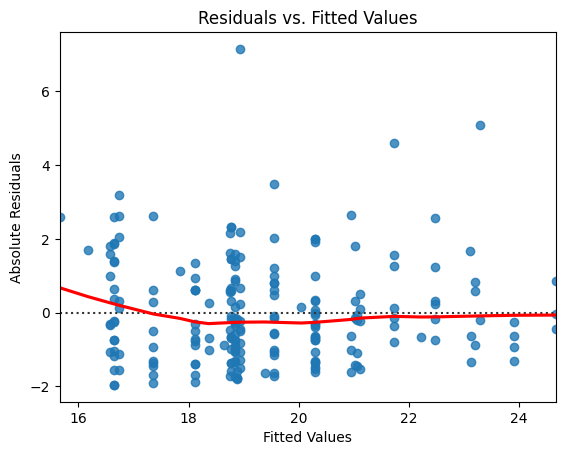

In [29]:
# график абсолютных значений остатков против предсказанных значений
y_pred = model.fittedvalues

residuals = np.abs(model.resid)

sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Absolute Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

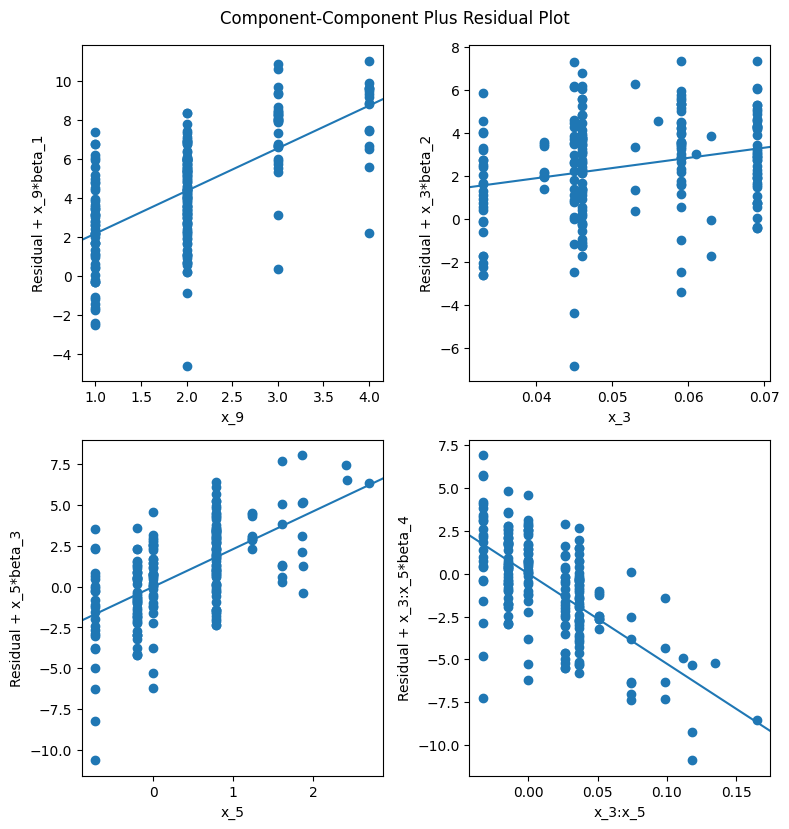

In [30]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(model, fig=fig)

> - форма распределения остатков имеет вытянутый хвост слева
> - на графике абсолютных значений остатков против предсказанных значений форма разброса остатков имеет воронкообразную форму, что свидетельствует о гетероскедастичности (неоднородности)

### Выводы

In [31]:
# продублируем итоговую модель

y = df_for_reg_model['y']
formula = 'x_9 + x_3*x_5'

model = smf.ols(formula='y ~ ' + formula, data=df_for_reg_model).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     37.01
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           2.97e-23
Time:                        21:58:16   Log-Likelihood:                -467.63
No. Observations:                 209   AIC:                             945.3
Df Residuals:                     204   BIC:                             962.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3830      0.983     12.601      0.0

> скорректированный коэффициент детерминации (**Adj. R-squared**) в итоге составил 40,9%, что означает, что модель объясняет значительную часть вариации зависимой переменной, но при этом в будущем её вполне можно улучшить доп. предикторами
> 
> для предсказательной функции модель слаба, но для описательной подходит: **F-статистика** показывает p-value, близкое к 0, что говорит о значимости коэффициента детерминации и модели в целом
>
> остатки распределены не нормально, о чём свидетельствует тест **Omnibus** и его p-value, а также остальные метрики внизу модели, что также подтверждается при визуальной оценке остатков (выше)

наименования переменных
   - {'Money Raised (in USD)':'y',
   - 'Инфляция':'x_3',
   - 'Индекс глобальной инновационной активности (GII)':'x_5',
   - 'Funding Type (dummy)': 'x_9'}

> **Коэффициенты модели:**
> - интерсепт задаёт базовое значение у при прочих нулевых предикторах
> - х_3 ('Инфляция'): положительное значимое влияние на у. Инфляция обосновывает рост цен в исследуемом заказчиком секторе мировой экономики, а значит, увеличиваются и суммы инвестиций в стартапы
> - при этом взаимодействие x_3 * x_5 ('Инфляция' * 'Индекс глобальной инновационной активности') показывает отрицательное влияние. Это может говорить о том, что чем больше инновационный потенциал и показатель инновационной деятельности в той или иной стране, тем, наоборот, чувствительнее её инвестиционный климат к колебаниям инфляции (с тенденцией снижать инвестиции в стартапы во время роста инфляции)
> - х_9 ('Funding Type'): инвестиционный раунд стартапа - самая значимая переменная для у. Соотвественно, чем дальше стартап продвинулся по раундам инвестиций, тем больше денег он получит